In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

# Table

In [3]:
data_path = "data.05_15_23_39"


def read_json_lines_to_df(file_path):
    df = pd.read_json(open(file_path, "r", encoding="utf8"), lines=True)
    return df


def get_sample_df(data_path=data_path, task="text_summarization"):
    df1 = read_json_lines_to_df(f"{data_path}/{task}.txt")
    df2 = read_json_lines_to_df(f"{data_path}/{task}_result.txt")
    df3 = read_json_lines_to_df(f"{data_path}/{task}_ppl.txt")
    df4 = read_json_lines_to_df(f"{data_path}/{task}_score.txt")
    # merge by id, watermark_process column
    df = pd.merge(df1, df2, on=["id", "watermark_processor"])
    df = pd.merge(df, df3, on=["id", "watermark_processor"])
    # df4 misses some rows, so we use left join
    df = pd.merge(df, df4, on=["id", "watermark_processor"], how="left")
    return df


def get_bootstrap_df(data_path=data_path, task="machine_translation"):
    df1 = read_json_lines_to_df(f"{data_path}/{task}_bleu.txt")
    return df1


def extract_watermark_info(df, return_wp_list=False):
    show_wp = [
        "No Watermark",
        "$\delta$-reweight",
        "$\gamma$-reweight",
        "$\delta$-reweight (woh)",
        "$\gamma$-reweight (woh)",
    ]
    john_wps_set = set()

    def map_wp_str(wp_str):
        if "Delta" in wp_str or "Gamma" in wp_str:
            woh = ", True)" in wp_str
            if "Delta" in wp_str and not woh:
                return show_wp[1]
            elif "Delta" in wp_str and woh:
                return show_wp[3]
            elif "Gamma" in wp_str and not woh:
                return show_wp[2]
            elif "Gamma" in wp_str and woh:
                return show_wp[4]
        elif "John" in wp_str:
            import re

            delta = re.findall(r"delta=(\d+\.?\d*)", wp_str)[0]
            n = "Soft" + f"($\delta$={delta})"
            john_wps_set.add(n)
            return n
        if wp_str == "None":
            return show_wp[0]
        else:
            raise ValueError("Unknown watermark: {}".format(wp_str))

    df = df.assign(show_wp_name=df["watermark_processor"].apply(map_wp_str))
    john_wps = sorted(list(john_wps_set))
    show_wp = show_wp + john_wps
    if return_wp_list:
        return df, show_wp
    else:
        return df


def sample_df_2_stat(df, bootstrap=False, show_wp=None):
    sdf = df.melt(
        id_vars=["show_wp_name"],
        value_vars=[c for c in df.columns if df[c].dtype == np.float64],
        var_name="score",
        value_name="value",
    )
    sdf = sdf.groupby(["show_wp_name", "score"]).agg(["mean", "std", "count"])
    if not bootstrap:
        format_fn = lambda x: "{:.4f}±{:.4f}".format(
            x["mean"], x["std"] / np.sqrt(x["count"])
        )
    else:
        format_fn = lambda x: "{:.4f}±{:.4f}".format(x["mean"], x["std"])
    sdf = sdf["value"].apply(format_fn, axis=1).unstack()
    if show_wp:
        sdf = sdf.loc[show_wp]
    return sdf

def merge_stat_df(df1, df2):
    df = pd.merge(df1, df2, left_index=True, right_index=True)
    return df

In [4]:
tsdf, show_wp = extract_watermark_info(get_sample_df(), return_wp_list=True)
mtdf = extract_watermark_info(get_sample_df(task="machine_translation"))
mtbsdf = extract_watermark_info(get_bootstrap_df())

In [5]:
sample_df_2_stat(tsdf, show_wp=show_wp)

score,bertscore.f1,bertscore.precision,bertscore.recall,best_dist_q,best_sum_score,ppl,rouge1,rouge2,rougeL
show_wp_name,,,,,,,,,
No Watermark,0.3270±0.0008,0.3180±0.0009,0.3361±0.0010,nan±nan,nan±nan,5.0240±0.0182,0.3856±0.0009,0.1388±0.0008,0.2445±0.0008
$\delta$-reweight,0.3271±0.0008,0.3180±0.0009,0.3365±0.0010,0.0527±0.0005,67.4589±0.2312,5.0222±0.0180,0.3857±0.0009,0.1392±0.0008,0.2451±0.0008
$\gamma$-reweight,0.3269±0.0008,0.3180±0.0009,0.3360±0.0010,0.0289±0.0004,16.8654±0.0585,5.0187±0.0179,0.3860±0.0009,0.1397±0.0008,0.2451±0.0008
$\delta$-reweight (woh),0.3276±0.0008,0.3185±0.0009,0.3370±0.0010,0.0100±0.0003,71.8604±0.2376,4.9999±0.0177,0.3857±0.0009,0.1398±0.0008,0.2455±0.0008
$\gamma$-reweight (woh),0.3269±0.0008,0.3178±0.0009,0.3361±0.0010,0.0068±0.0002,18.4573±0.0575,5.0096±0.0181,0.3856±0.0009,0.1393±0.0008,0.2447±0.0008
Soft($\delta$=0.0),0.3270±0.0008,0.3180±0.0009,0.3361±0.0010,nan±nan,nan±nan,5.0240±0.0182,0.3856±0.0009,0.1388±0.0008,0.2445±0.0008
Soft($\delta$=1.0),0.3235±0.0008,0.3092±0.0009,0.3382±0.0009,nan±nan,nan±nan,5.3127±0.0182,0.3820±0.0009,0.1344±0.0007,0.2400±0.0007
Soft($\delta$=2.0),0.3121±0.0008,0.2908±0.0008,0.3339±0.0009,nan±nan,nan±nan,6.2533±0.0216,0.3717±0.0008,0.1238±0.0007,0.2293±0.0007


In [6]:
merge_stat_df(sample_df_2_stat(mtdf, show_wp=show_wp), sample_df_2_stat(mtbsdf, bootstrap=True, show_wp=show_wp))

score,bertscore.f1,bertscore.precision,bertscore.recall,best_dist_q,best_sum_score,ppl,bleu
show_wp_name,,,,,,,
No Watermark,0.5593±0.0035,0.5450±0.0036,0.5736±0.0035,nan±nan,nan±nan,86.4561±8.3738,21.8060±0.3492
$\delta$-reweight,0.5633±0.0034,0.5492±0.0036,0.5775±0.0035,0.0829±0.0037,14.6106±0.2826,88.6146±12.9439,21.7424±0.3396
$\gamma$-reweight,0.5615±0.0034,0.5476±0.0036,0.5756±0.0035,0.0570±0.0026,3.6802±0.0692,91.0898±9.2638,21.8358±0.3437
$\delta$-reweight (woh),0.5685±0.0033,0.5545±0.0035,0.5827±0.0033,0.0381±0.0029,15.7751±0.2866,72.8900±4.0667,21.9003±0.3429
$\gamma$-reweight (woh),0.5626±0.0033,0.5485±0.0035,0.5768±0.0033,0.0280±0.0019,4.1657±0.0715,80.9436±6.2886,21.7704±0.3474
Soft($\delta$=0.0),0.5593±0.0035,0.5450±0.0036,0.5736±0.0035,nan±nan,nan±nan,86.4561±8.3738,21.8060±0.3492
Soft($\delta$=1.0),0.5515±0.0035,0.5364±0.0036,0.5666±0.0035,nan±nan,nan±nan,95.6581±9.5525,21.0314±0.3445
Soft($\delta$=2.0),0.5380±0.0034,0.5222±0.0036,0.5538±0.0035,nan±nan,nan±nan,98.4242±7.8681,19.4665±0.3344


# violin diagram

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sample_df(df, score:str, print_name:str, show_wp=None, show_mean=False, violin_kwargs={}):
    sns.violinplot(data=df, x="show_wp_name", y=score, order=show_wp, **violin_kwargs)
    plt.ylabel(print_name)
    plt.xlabel("")
    if show_mean:
        plt.axhline(
            df[df.show_wp_name == "No Watermark"][score].mean(),
            color="red",
            linestyle="--",
            label="Mean performace w/o watermark",
        )
        plt.legend(loc="upper left")
    plt.xticks(rotation=15, ha='center')

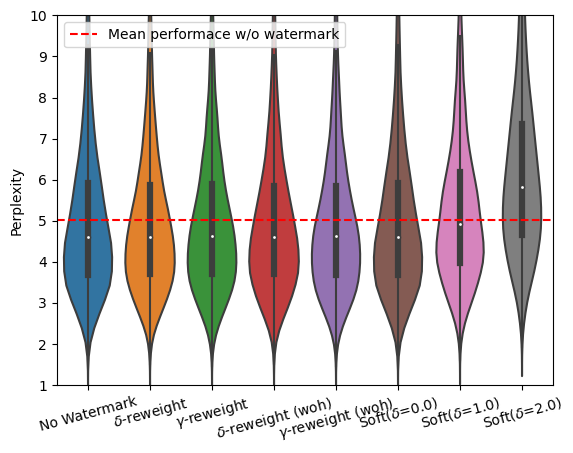

<Figure size 640x480 with 0 Axes>

In [8]:
#plot_sample_df(tsdf, "bertscore.f1", "F1", show_wp=show_wp, show_mean=True)
#plt.ylim(0.1, 0.6)
#plot_sample_df(tsdf, "bertscore.precision", "Precision", show_wp=show_wp, show_mean=True)
#plt.ylim(0.1, 0.6)
#plot_sample_df(tsdf, "bertscore.recall", "Recall", show_wp=show_wp, show_mean=True)
#plt.ylim(0.1, 0.6)
#plot_sample_df(tsdf, "rouge1", "ROUGE-1", show_wp=show_wp, show_mean=True)
#plt.ylim(0.15, 0.65)
#plot_sample_df(tsdf, "rouge2", "ROUGE-2", show_wp=show_wp, show_mean=True)
#plt.ylim(0.0, 0.4)
plot_sample_df(tsdf, "ppl", "Perplexity", show_wp=show_wp, show_mean=True)
plt.ylim(1, 10)
plt.show()
plt.savefig("figures/Violin_TS.pdf", format="pdf")

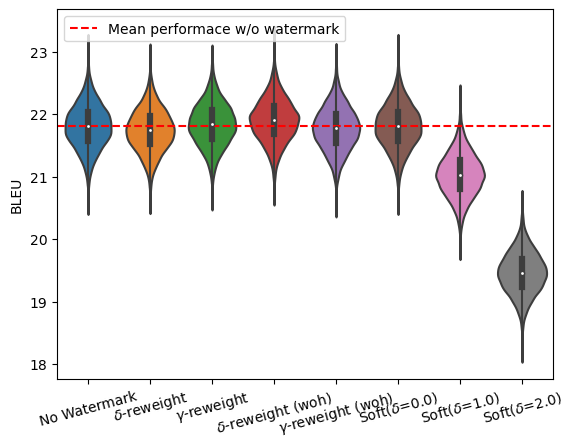

<Figure size 640x480 with 0 Axes>

In [9]:
#plot_sample_df(mtdf, "bertscore.f1", "F1", show_wp=show_wp, show_mean=True)
#plt.ylim(0.2, 1.0)
#plot_sample_df(mtdf, "bertscore.precision", "Precision", show_wp=show_wp, show_mean=True)
#plt.ylim(0.1, 1.0)
#plot_sample_df(mtdf, "bertscore.recall", "Recall", show_wp=show_wp, show_mean=True)
#plt.ylim(0.1, 1.0)
plot_sample_df(mtbsdf, "bleu", "BLEU", show_wp=show_wp, show_mean=True)
plt.show()
plt.savefig("figures/Violin_MT.pdf", format="pdf")